# Data Loading and Preprocessing

#### Data Loading

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [2]:
df = pd.read_csv('./dataset/Dry_Bean_Dataset.csv')
df

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272751,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13606,42097,759.696,288.721612,185.944705,1.552728,0.765002,42508,231.515799,0.714574,0.990331,0.916603,0.801865,0.006858,0.001749,0.642988,0.998385,DERMASON
13607,42101,757.499,281.576392,190.713136,1.476439,0.735702,42494,231.526798,0.799943,0.990752,0.922015,0.822252,0.006688,0.001886,0.676099,0.998219,DERMASON
13608,42139,759.321,281.539928,191.187979,1.472582,0.734065,42569,231.631261,0.729932,0.989899,0.918424,0.822730,0.006681,0.001888,0.676884,0.996767,DERMASON
13609,42147,763.779,283.382636,190.275731,1.489326,0.741055,42667,231.653247,0.705389,0.987813,0.907906,0.817457,0.006724,0.001852,0.668237,0.995222,DERMASON


### Check for nullish values

The isna function checks if there are any nullish values in the dataframe or not

In [3]:
df.isna().any()

Area               False
Perimeter          False
MajorAxisLength    False
MinorAxisLength    False
AspectRation       False
Eccentricity       False
ConvexArea         False
EquivDiameter      False
Extent             False
Solidity           False
roundness          False
Compactness        False
ShapeFactor1       False
ShapeFactor2       False
ShapeFactor3       False
ShapeFactor4       False
Class              False
dtype: bool

From the below bar graph, we can infer following points:
1. There aren't any out-of-place/nullish class values
2. We need to convert the string values of class to numerical representation
3. The class distribution is unbalanced, so the training data needs to be split with stratification.

<Axes: xlabel='Class'>

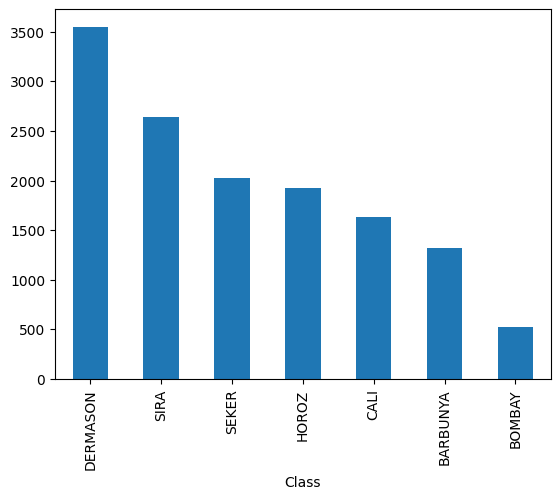

In [4]:
df['Class'].value_counts().plot(kind='bar')

### Converting string to numerical representation

In [5]:
encoder = LabelEncoder()
df['Class_numerical'] = encoder.fit_transform(df['Class'])

In [6]:
encoder.inverse_transform([0, 1, 2, 3, 4, 6, 5])

array(['BARBUNYA', 'BOMBAY', 'CALI', 'DERMASON', 'HOROZ', 'SIRA', 'SEKER'],
      dtype=object)

### Normalizing dataset attributes

From the histograms below, it can be observed that the value range of the attributes are high and needs to be standardized for ML models to converge faster

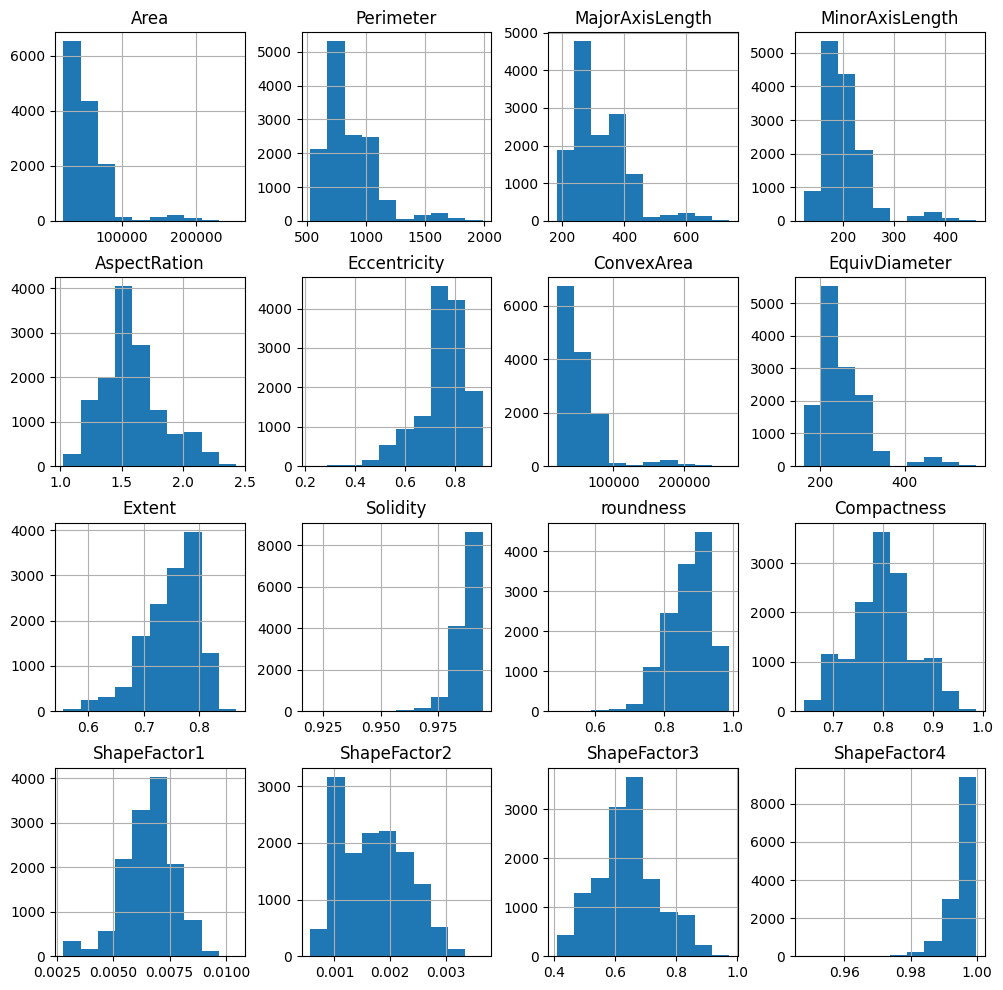

In [7]:
_ = df.iloc[:, :-2].hist(figsize=(12, 12))

In [8]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df.iloc[:, :-2])
scaled_dataset = pd.concat(
    [
        pd.DataFrame(scaled_features, columns=df.columns[:-2]),
        pd.Series(df['Class_numerical']),
    ],
    axis=1,
)
scaled_dataset.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class_numerical
0,-0.840749,-1.143319,-1.306598,-0.631153,-1.565053,-2.185720,-0.841451,-1.063341,0.289087,0.367614,1.423867,1.839116,0.680786,2.402173,1.925723,0.838371,5
1,-0.829188,-1.013924,-1.395911,-0.434445,-1.969784,-3.686040,-0.826102,-1.044217,0.697477,-0.462907,0.231054,2.495449,0.367967,3.100894,2.689702,0.771138,5
2,-0.807157,-1.078829,-1.252357,-0.585735,-1.514291,-2.045336,-0.808704,-1.008084,0.578195,0.518417,1.252865,1.764843,0.603129,2.235091,1.841356,0.916755,5
3,-0.785741,-0.977215,-1.278825,-0.439290,-1.741618,-2.742211,-0.773975,-0.973337,0.671260,-2.241767,0.515049,2.081715,0.401718,2.515075,2.204250,-0.197985,5
4,-0.781239,-1.097384,-1.380471,-0.266663,-2.117993,-4.535028,-0.784286,-0.966080,0.476020,0.804772,1.874992,2.765330,0.118268,3.270983,3.013462,0.939640,5


As you can see in below histograms, the range of features are normalized

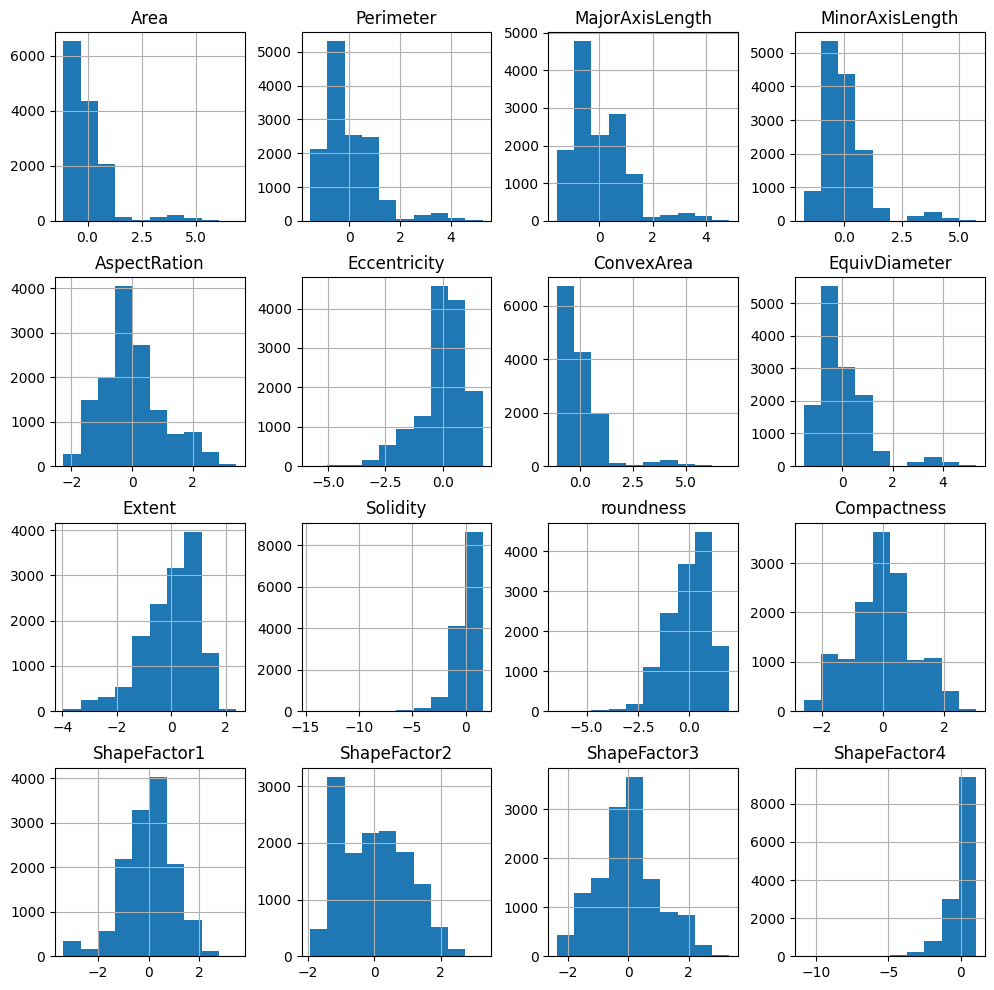

In [9]:
_ = scaled_dataset.iloc[:, :-1].hist(figsize=(12, 12))

# Data analysis

#### Correlations

From the correlations heatmap below, it can be observed:
1. Some features have very high correlation with other variables (so they are not independent)
2. Some attributes like AspectRation, Extent, ShapeFactor1, ShapeFactor4 have direct correlation to some extent with labels

In [10]:
scaled_dataset.corr().style.background_gradient(cmap='coolwarm')

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class_numerical
Area,1.000000,0.966722,0.931834,0.951602,0.241735,0.267481,0.999939,0.984968,0.054345,-0.196585,-0.357530,-0.268067,-0.847958,-0.639291,-0.272145,-0.355721,-0.475252
Perimeter,0.966722,1.000000,0.977338,0.913179,0.385276,0.391066,0.967689,0.991380,-0.021160,-0.303970,-0.547647,-0.406857,-0.864623,-0.767592,-0.408435,-0.429310,-0.507638
MajorAxisLength,0.931834,0.977338,1.000000,0.826052,0.550335,0.541972,0.932607,0.961733,-0.078062,-0.284302,-0.596358,-0.568377,-0.773609,-0.859238,-0.568185,-0.482527,-0.455175
MinorAxisLength,0.951602,0.913179,0.826052,1.000000,-0.009161,0.019574,0.951339,0.948539,0.145957,-0.155831,-0.210344,-0.015066,-0.947204,-0.471347,-0.019326,-0.263749,-0.458492
AspectRation,0.241735,0.385276,0.550335,-0.009161,1.000000,0.924293,0.243301,0.303647,-0.370184,-0.267754,-0.766979,-0.987687,0.024593,-0.837841,-0.978592,-0.449264,-0.116332
Eccentricity,0.267481,0.391066,0.541972,0.019574,0.924293,1.000000,0.269255,0.318667,-0.319362,-0.297592,-0.722272,-0.970313,0.019920,-0.860141,-0.981058,-0.449354,-0.200356
ConvexArea,0.999939,0.967689,0.932607,0.951339,0.243301,0.269255,1.000000,0.985226,0.052564,-0.206191,-0.362083,-0.269922,-0.847950,-0.640862,-0.274024,-0.362049,-0.477459
EquivDiameter,0.984968,0.991380,0.961733,0.948539,0.303647,0.318667,0.985226,1.000000,0.028383,-0.231648,-0.435945,-0.327650,-0.892741,-0.713069,-0.330389,-0.392512,-0.481099
Extent,0.054345,-0.021160,-0.078062,0.145957,-0.370184,-0.319362,0.052564,0.028383,1.000000,0.191389,0.344411,0.354212,-0.141616,0.237956,0.347624,0.148502,-0.031184
Solidity,-0.196585,-0.303970,-0.284302,-0.155831,-0.267754,-0.297592,-0.206191,-0.231648,0.191389,1.000000,0.607150,0.303766,0.153388,0.343559,0.307662,0.702163,0.321283


# Model Training

## Train test split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    scaled_dataset.iloc[:, :-1],
    scaled_dataset["Class_numerical"],
    test_size=0.2,
    random_state=42,
    shuffle=True,
    stratify=scaled_dataset["Class_numerical"],
)

## Random Forest

In [12]:
params = {
    # "n_estimators": [100, 200, 300],
    # "max_depth": [10, 12],
    "n_estimators": [200],
    "max_depth": [12],
}
stratified_split = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=42)
gridsearch_rf = GridSearchCV(
    RandomForestClassifier(n_jobs=-1),
    params,
    cv=stratified_split,
    n_jobs=-1,
    verbose=1,
)
gridsearch_rf.fit(X_train, y_train)

# Scores
gridsearch_rf.score(X_train, y_train), gridsearch_rf.score(X_test, y_test)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


(0.9841109478324761, 0.9214102093279471)

In [13]:
# If you uncomment the commented parameters and comment out the current parameters,
# you will get the following output

# gridsearch_rf.best_params_
# Output - {'max_depth': 12, 'n_estimators': 200}

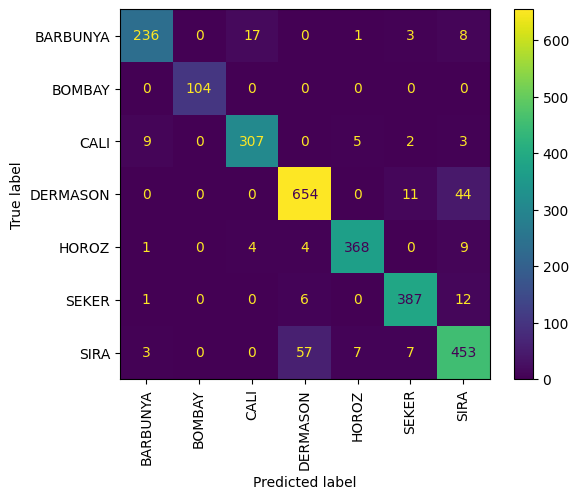

In [14]:
y_pred = gridsearch_rf.predict(X_test)
matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=encoder.inverse_transform([0, 1, 2, 3, 4, 5, 6]),
    xticks_rotation="vertical",
)

In [15]:
def f1_score_weighted(y_true, y_pred):
    matrix = confusion_matrix(y_true, y_pred)
    precision = np.diag(matrix) / matrix.sum(axis=0)
    recall = np.diag(matrix) / matrix.sum(axis=1)
    f1 = 2 * precision * recall / (precision + recall)
    weighted_f1 = np.sum(f1 * matrix.sum(axis=1) / matrix.sum())
    return weighted_f1

In [16]:
f1_score_weighted(y_test, y_pred)

0.9214435476332757

In [17]:
# If you uncomment below code, you will get the following output
# The output is the same as the formula calculation above

# from sklearn.metrics import f1_score

# f1_score(y_test, y_pred, average="weighted")

# Output: 0.922548837254795

## Additional Algorithm - SVM

In [18]:
params = {
    # "C": [10, 100, 1000],
    # "kernel": ["linear", "rbf", "sigmoid", "poly"],
    # 'degree': [2, 4, 6]
    "C": [100],
    "kernel": ["rbf"],
    'degree': [2]
    
}
stratified_split = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=42)
gridsearch_svc = GridSearchCV(
    SVC(random_state=42),
    params,
    cv=stratified_split,
    n_jobs=-1,
    verbose=1,
)
gridsearch_svc.fit(X_train, y_train)

# Scores
gridsearch_svc.score(X_train, y_train), gridsearch_svc.score(X_test, y_test)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


(0.9456282145481264, 0.9250826294528094)

In [19]:
# If you uncomment the commented parameters and comment out the current parameters,
# you will get the following output

# gridsearch_svc.best_params_
# Output - {'C': 100, 'degree': 2, 'kernel': 'rbf'}

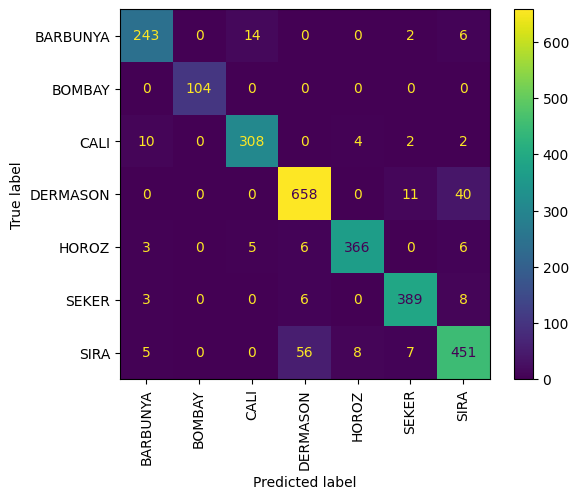

In [20]:
y_pred = gridsearch_svc.predict(X_test)
matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=encoder.inverse_transform([0, 1, 2, 3, 4, 5, 6]),
    xticks_rotation="vertical",
)

In [21]:
f1_score_weighted(y_test, y_pred)

0.9249781563467131

In [22]:
# If you uncomment below code, you will get the following output
# The output is the same as the formula calculation above

# from sklearn.metrics import f1_score

# f1_score(y_test, y_pred, average="weighted")

# Output: 0.924978156346713

## Additional Algorithm - KNN

In [23]:
params = {
    # "n_neighbors": [3, 5, 7],
    # "weights": ["uniform", "distance"],
    # "algorithm": ["ball_tree", "kd_tree", "brute"],
    # "leaf_size": [10, 30, 50],
    # "p": [1, 2, 3],
    "n_neighbors": [7],
    "weights": ["uniform"],
    "algorithm": ["ball_tree"],
    "leaf_size": [10],
    "p": [2],
}
stratified_split = StratifiedShuffleSplit(n_splits=6, test_size=0.1, random_state=42)
gridsearch_svc = GridSearchCV(
    KNeighborsClassifier(n_jobs=-1),
    params,
    cv=stratified_split,
    n_jobs=-1,
    verbose=1,
)
gridsearch_svc.fit(X_train, y_train)

# Scores
gridsearch_svc.score(X_train, y_train), gridsearch_svc.score(X_test, y_test)

Fitting 6 folds for each of 1 candidates, totalling 6 fits


(0.9391991182953711, 0.9140653690782226)

In [24]:
# If you uncomment the commented parameters and comment out the current parameters,
# you will get the following output

# gridsearch_svc.best_params_
# Output - {'algorithm': 'ball_tree',
#  'leaf_size': 10,
#  'n_neighbors': 7,
#  'p': 2,
#  'weights': 'uniform'}

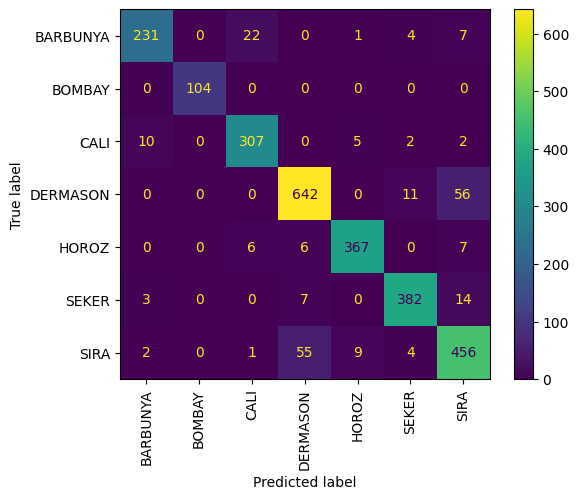

In [25]:
y_pred = gridsearch_svc.predict(X_test)
matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=encoder.inverse_transform([0, 1, 2, 3, 4, 5, 6]),
    xticks_rotation="vertical",
)

In [26]:
f1_score_weighted(y_test, y_pred)

0.9142227933487639

In [27]:
# If you uncomment below code, you will get the following output
# The output is the same as the formula calculation above

# from sklearn.metrics import f1_score

# f1_score(y_test, y_pred, average='weighted')

# Output: 0.9142227933487637

## Additional Deep Learning Algorithm - Conv1D

In [28]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchinfo import summary

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
print(f"Using {device} device for torch models")

Using mps device for torch models


In [29]:
class Conv1DNNModel(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.conv1d_relu_stack = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=128, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Flatten(),
            nn.Linear(32 * 10, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, 7),
        )

    def forward(self, x):
        return self.conv1d_relu_stack(x)

In [30]:
learning_rate = 1e-1
batch_size = 32
epochs = 30

conv1d_model = Conv1DNNModel().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(conv1d_model.parameters(), lr=learning_rate)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)
summary(conv1d_model, input_size=(batch_size, 1, 16))

Layer (type:depth-idx)                   Output Shape              Param #
Conv1DNNModel                            [32, 7]                   --
├─Sequential: 1-1                        [32, 7]                   --
│    └─Conv1d: 2-1                       [32, 128, 14]             512
│    └─ReLU: 2-2                         [32, 128, 14]             --
│    └─BatchNorm1d: 2-3                  [32, 128, 14]             256
│    └─Conv1d: 2-4                       [32, 64, 12]              24,640
│    └─ReLU: 2-5                         [32, 64, 12]              --
│    └─BatchNorm1d: 2-6                  [32, 64, 12]              128
│    └─Conv1d: 2-7                       [32, 32, 10]              6,176
│    └─ReLU: 2-8                         [32, 32, 10]              --
│    └─BatchNorm1d: 2-9                  [32, 32, 10]              64
│    └─Flatten: 2-10                     [32, 320]                 --
│    └─Linear: 2-11                      [32, 32]                  10,272
│

In [31]:
def training_loop(
    train_loader,
    model: nn.Module,
    loss_fn: nn.CrossEntropyLoss,
    optimizer: torch.optim.Optimizer,
):
    model.train()
    for X_batch, y_batch in train_loader:
        pred = model(X_batch)
        loss = loss_fn(pred, y_batch)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    model.eval()
    with torch.no_grad():
        pred = model(train_loader.dataset.tensors[0])
        y_train = train_loader.dataset.tensors[1]
        print(
            f"Training metrics\nLoss: {loss.item()}\nF1 Score: {f1_score_weighted(y_train.argmax(dim=1), pred.argmax(dim=1))}"
        )


def test_nn_model(
    test_dataset: TensorDataset, model: nn.Module, loss_fn: nn.CrossEntropyLoss
):
    model.eval()
    with torch.no_grad():
        X_test, y_test = test_dataset.tensors
        pred = model(X_test)
        loss = loss_fn(pred, y_test)

        print(
            f"Test metrics\nLoss: {loss.item()}\nF1 Score: {f1_score_weighted(y_test.argmax(dim=1), pred.argmax(dim=1))}"
        )
        return f1_score_weighted(y_test.argmax(dim=1), pred.argmax(dim=1))

In [32]:
one_hot_encoder = OneHotEncoder(
    sparse_output=False,
    max_categories=scaled_dataset["Class_numerical"].value_counts().shape[0],
)
_ = one_hot_encoder.fit(scaled_dataset["Class_numerical"].values.reshape(-1, 1))
y_train_one_hot = one_hot_encoder.transform(y_train.values.reshape(-1, 1))
y_test_one_hot = one_hot_encoder.transform(y_test.values.reshape(-1, 1))

In [33]:
train_dataset = TensorDataset(
    torch.tensor(X_train.values.reshape((-1, 1, 16)), dtype=torch.float32),
    torch.tensor(y_train_one_hot, dtype=torch.float32),
)
test_dataset = TensorDataset(
    torch.tensor(X_test.values.reshape((-1, 1, 16)), dtype=torch.float32),
    torch.tensor(y_test_one_hot, dtype=torch.float32),
)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [34]:
best_f1_score = 0
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}\n-------------------------------")
    training_loop(train_loader, conv1d_model, loss_fn, optimizer)
    lr_scheduler.step()
    print()

    test_f1_score = test_nn_model(test_dataset, conv1d_model, loss_fn)
    if (test_f1_score > best_f1_score):
        print("\nFound better model, saving it...")
        best_f1_score = test_f1_score
        torch.save(conv1d_model, "models/best_model.pth")
    
    print()

Epoch 1
-------------------------------
Training metrics
Loss: 0.28065845370292664
F1 Score: 0.9144777049689797

Test metrics
Loss: 0.27501899003982544
F1 Score: 0.9066431626242835

Found better model, saving it...

Epoch 2
-------------------------------
Training metrics
Loss: 0.05566123127937317
F1 Score: 0.9182457954799341

Test metrics
Loss: 0.2394191473722458
F1 Score: 0.9142207654205123

Found better model, saving it...

Epoch 3
-------------------------------
Training metrics
Loss: 1.0758640766143799
F1 Score: 0.9153677335718301

Test metrics
Loss: 0.26525142788887024
F1 Score: 0.9012820829485395

Epoch 4
-------------------------------
Training metrics
Loss: 0.04815886914730072
F1 Score: 0.9336388204701774

Test metrics
Loss: 0.21288739144802094
F1 Score: 0.9202600147679967

Found better model, saving it...

Epoch 5
-------------------------------
Training metrics
Loss: 0.08770391345024109
F1 Score: 0.9348878046923547

Test metrics
Loss: 0.22006748616695404
F1 Score: 0.92240408